# Basic tests with SimplePatternLearner module

In [1]:
import os
import torch
import matplotlib.pyplot as plt

from dataset.utils import load_pickle_data, save_dict
from ML.utils import correlation
from ML.architecture import SimplePatternLearner, CorrelationLoss
from ripdalib.variations.transform import list_to_matrix, matrix_to_list
from ripdalib.variations.plot import plot_matrix, plot_correlation, plot_patterns_from_correlation

## Initiation

In [68]:
IMAGE = load_pickle_data(os.path.join("Fugues_data", "data_8.pkl"))["BWV_0860"]
MAX_EPOCH = 400
LEARNING_RATE = 0.1
EPSILON = 0.0000001
PATTERN_MAXSIZE = (4*8, 13)

MINDIV = 8 #from Fugues_data.midi_to_pkl import MINDIV

torch.manual_seed(689)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
matrix_image = list_to_matrix(IMAGE, MINDIV)

In [69]:
module = SimplePatternLearner(PATTERN_MAXSIZE)
loss = CorrelationLoss().absolute_regul(beta=0, smooth_function=3, mean_size=0) #0.8

## Training

In [73]:
torch.manual_seed(689)
#module.reset()
module.learn_pattern(matrix_image, loss, learning_rates=LEARNING_RATE, maxepoch=MAX_EPOCH, epsilon=EPSILON)

Training...:  10%|████▉                                            | 40/400 [00:03<00:30, 11.96it/s]

Current_loss = -5.970972537994385


Training...:  20%|█████████▊                                       | 80/400 [00:07<00:26, 11.93it/s]

Current_loss = -9.79465103149414


Training...:  23%|███████████▍                                     | 93/400 [00:08<00:26, 11.46it/s]

Epsilon was reached in 93 fits.
Last loss : -9.79480648


In [ ]:
SAVE = True
FILE = "temp.pkl"

if SAVE:
    save_dict(module.state_dict(), FILE)
else:
    module.load_state_dict(load_pickle_data(FILE))

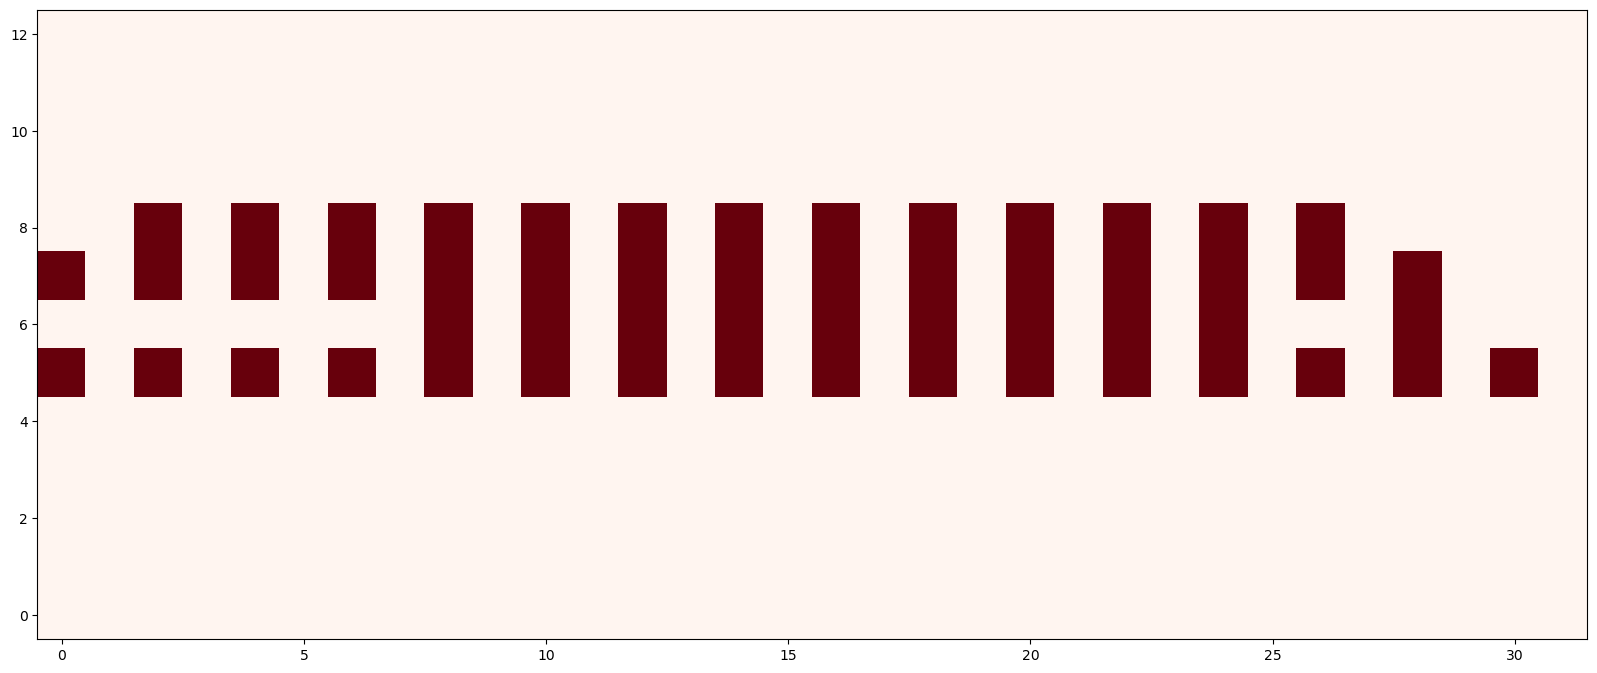

tensor(1.)


In [74]:
plot_correlation(module.pattern.squeeze((0,1)))
with torch.no_grad():
    print(torch.max(module.pattern))

In [8]:
print(torch.sum(module.pattern))
print(matrix_to_list(module.pattern.squeeze((0,1)) > 0.5, mindiv=MINDIV))

tensor(12.)
[(Fraction(1, 8), 8), (Fraction(5, 8), 6), (Fraction(5, 8), 7), (Fraction(9, 8), 5), (Fraction(9, 8), 6), (Fraction(13, 8), 4), (Fraction(13, 8), 6), (Fraction(13, 8), 7), (Fraction(17, 8), 5), (Fraction(17, 8), 6), (Fraction(21, 8), 6), (Fraction(25, 8), 6)]


In [9]:
test = module.pattern.squeeze((0,1))
((test.sum() - 10)**2).sum()

tensor(4.)

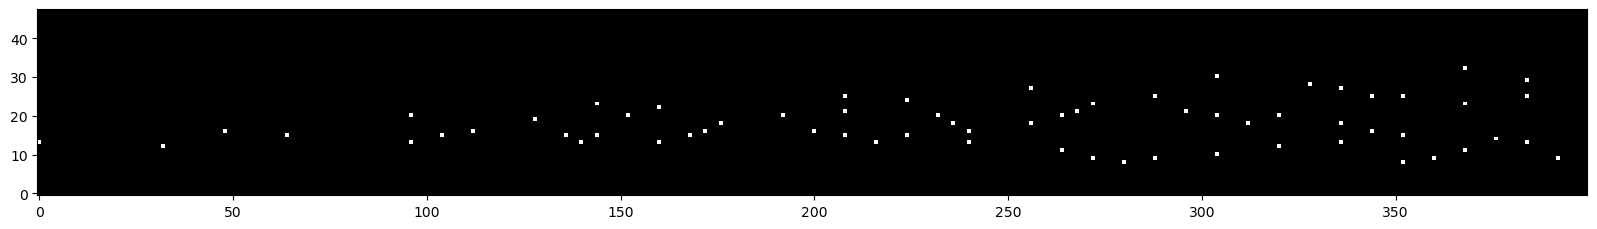

In [10]:
plot_matrix(matrix_image[:400])

dilatation on erosion of the pattern give 0 element.


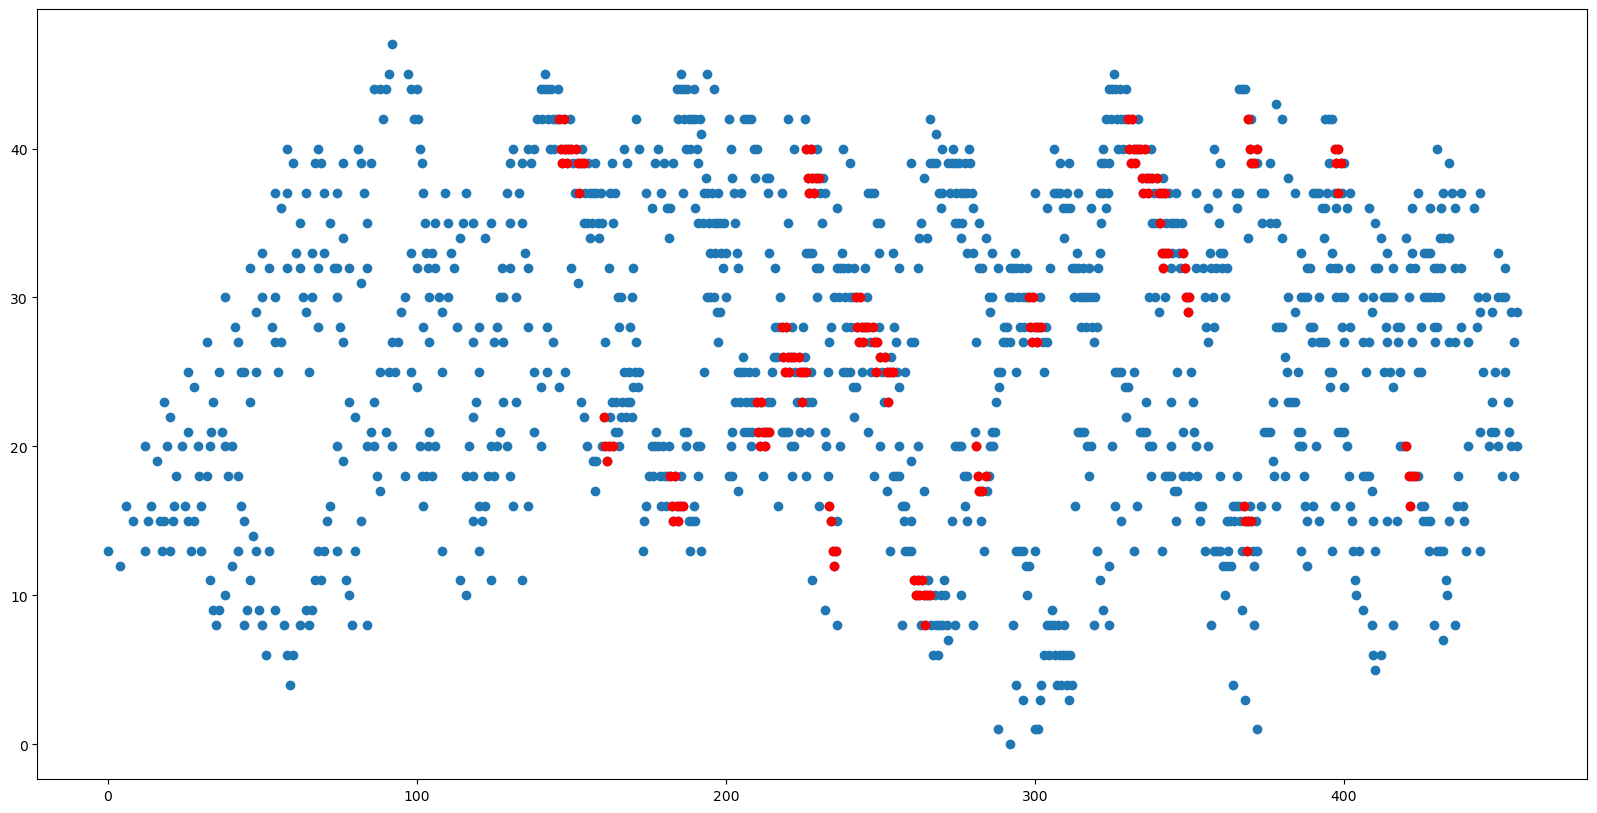

In [21]:
plot_patterns_from_correlation(module.correlation(matrix_image), IMAGE, module.pattern.squeeze((0,1)) >0.5, threshold=0.4, quantization=MINDIV)

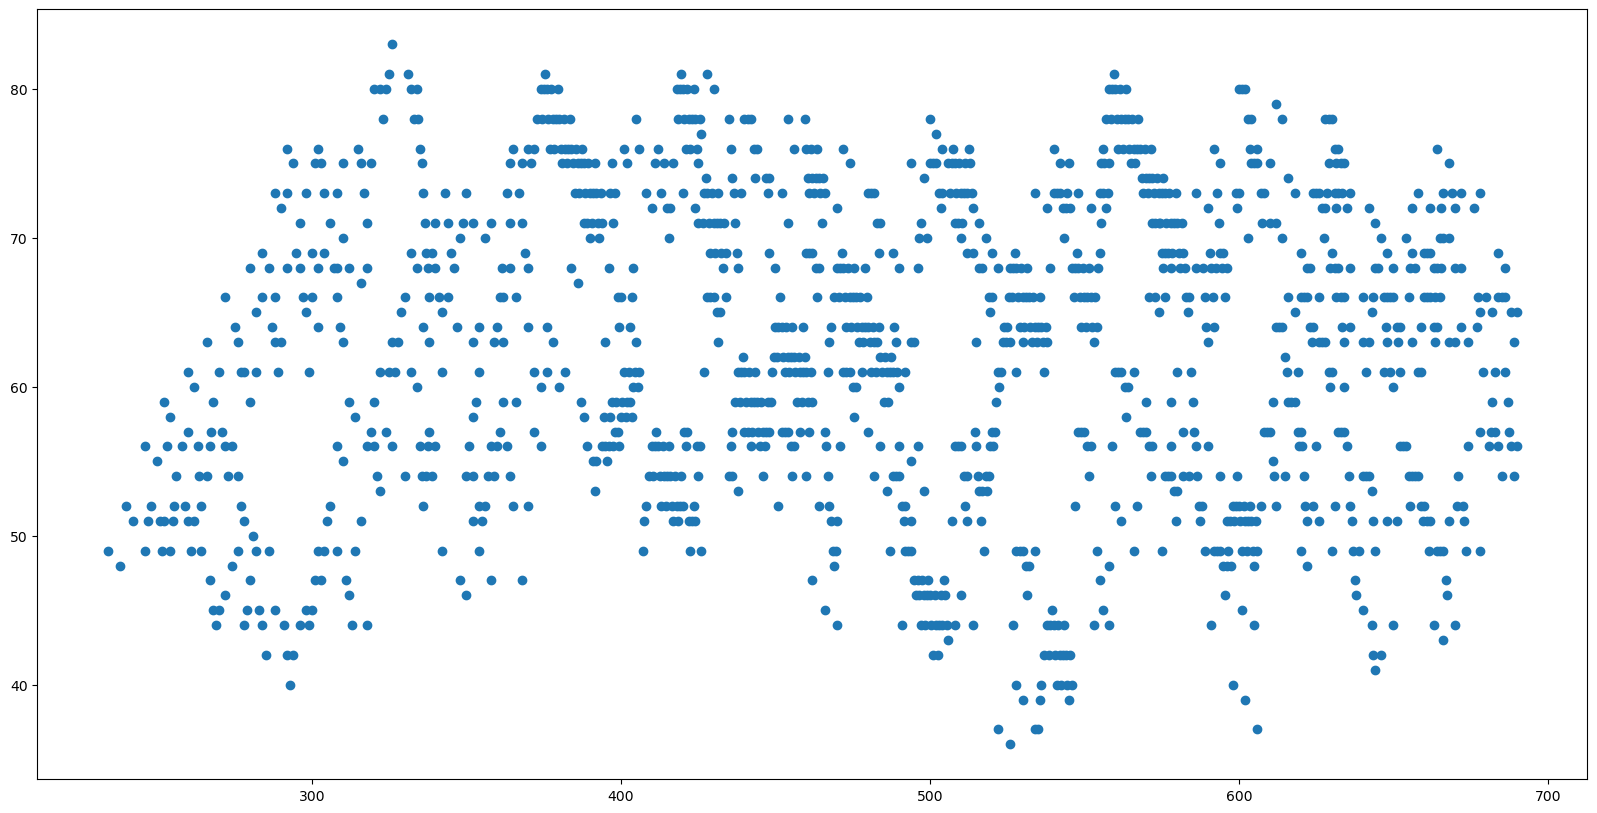

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(*zip(*IMAGE))
plt.show()

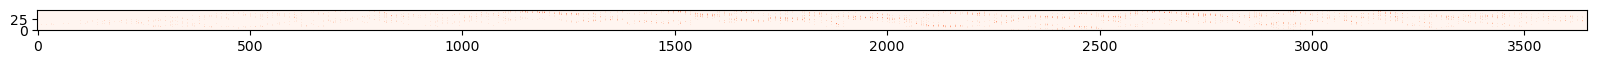

tensor(0.4167)


In [13]:
plot_correlation(module.correlation(matrix_image).squeeze((0,1)))
with torch.no_grad():
    print(torch.max(module.correlation(matrix_image)))

## Loss behavior

- The interaction between beta and the smooth function is really sensitive.
- The basic kernel learns extreme value
- Positive beta give noise map
- High Negative beta give the one element, from 0 to -high we get a decrease number of points in the pattern, but often it does not have exact apparition even once in the original piece
- Beta does not seem to be correlated with the input neither the pattern size, but deeper investigation should be done. An adaptative beta during training could give results.
- Generally the training find a suddent "local minimum hole" and have a quick deacreasing before stopping. In a bigger training with mini-batch training, we may find a better minimum
- for the loss, the best model is still to just "be on tatum time at nearly the same pitch" if we tune it a bit

Drawbacks :
- see this as an optiization problem is of course not optimal and create probable high instability
- Training on one example which must contain noise due to basic midi quantization (even if the files are mostly clean) must not be optimal.

Patterns usually have big "hole" at mindiv = 16, mindiv = 8 may be enough and will significantly improve the performance

Residuals : supprimer le pattern dominant et recommencer

Division d'un pattern en 2 avec les channels ?
Difference trop stricte ? #Future work, voir avec 1 seul déjà
Future path : PCA...